In [1]:
%gui qt

import mne
mne.viz.set_browser_backend('qt')
mne.viz.set_3d_backend('pyvistaqt')

Using qt as 2D backend.
Using pyvistaqt 3d backend.


Channels marked as bad:
none
Channels marked as bad:
none


In [2]:
from pathlib import Path
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path(os.getcwd())
print(f"Current working directory: {project_root}")
sys.path.append('/workspace/src')   # Add src directory to path

from preprocessing import lfp_io, eeg_io, bids_export, visualization, alignment

print("✓ Modules loaded successfully")

Current working directory: /workspace
✓ Modules loaded successfully


## 1. Configuration

In [3]:

# Define paths (use relative paths)

# ---- Base directories ----
DATA_ROOT = project_root / "shared" / "data" / "raw"
RESULTS_ROOT = project_root / "shared" / "results"
BIDS_ROOT = project_root / "shared" / "data" / "bids_dataset"

# ---- Subject information ----
SUBJECT_NAME = "Roessner_Gerhard"
STIM_FREQ = 55  # Hz

subject_id = "001"
session_id = "01"
task_name = "StimOn55HzFull2"
diagnosis = "PD"

# ---- Input files ----
LFP_FILE = DATA_ROOT / SUBJECT_NAME / "lfp" / "brainsense_55Hz_2iter.json"
EEG_FILE = DATA_ROOT / SUBJECT_NAME / "eeg" / "Stim_On_55Hz_Full2.mff"
# HEAD_MODEL = DATA_ROOT / SUBJECT_NAME / "headmodel_ROESSNER.mat"
# COORD_XML = EEG_FILE.parent / "coordinates.xml"

# ---- Ensure output directories exist ----
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
BIDS_ROOT.mkdir(parents=True, exist_ok=True)

# ---- Print summary ----
print(f"Project root: {project_root}")
print(f"Data root: {DATA_ROOT}")
print(f"Results root: {RESULTS_ROOT}")
print(f"BIDS root: {BIDS_ROOT}")
# print(f"Head Model file: {HEAD_MODEL}")
# print(f"EEG Coordinates file: {COORD_XML}")



Project root: /workspace
Data root: /workspace/shared/data/raw
Results root: /workspace/shared/results
BIDS root: /workspace/shared/data/bids_dataset


## 2. Load and Process LFP Data

In [4]:
# Load LFP data
print("Loading LFP data...")
df_ts_sense, df_ts_stim, df_settings = lfp_io.load_lfp_data(LFP_FILE)

print(f"\nLFP Sensing data shape: {df_ts_sense.shape}")
print(f"LFP Stimulation data shape: {df_ts_stim.shape}")
print(f"\nSettings:")
df_settings

Loading LFP data...

LFP Sensing data shape: (29687, 2)
LFP Stimulation data shape: (236, 2)

Settings:


,subj_id,left_sr,left_ch,left_stim_contact,right_sr,right_ch,right_stim_contact
0,Roessner_Gerhard,250,+3-0,1,250,+3-0,1


In [5]:
df_ts_stim

,stim_amp_left,stim_amp_right
2024-02-14 09:43:30.750,3.0,3.5
2024-02-14 09:43:31.250,3.0,3.5
2024-02-14 09:43:31.750,3.0,3.5
2024-02-14 09:43:32.250,3.0,3.5
2024-02-14 09:43:32.750,3.0,3.5
...,...,...
2024-02-14 09:45:26.250,3.0,3.5
2024-02-14 09:45:26.750,3.0,3.5
2024-02-14 09:45:27.250,3.0,3.5
2024-02-14 09:45:27.750,3.0,3.5


In [6]:
import pandas as pd
import numpy as np

def find_stim_off_segments(df):
    """Return list of stim-off segments (start_idx, end_idx, segment_df)."""
    off_mask = (df['stim_amp_left'] == 0) & (df['stim_amp_right'] == 0)

    segments = []
    in_segment = False
    start = None

    for i, is_off in enumerate(off_mask):
        if is_off and not in_segment:
            in_segment = True
            start = i
        elif not is_off and in_segment:
            in_segment = False
            segments.append((start, i - 1, df.iloc[start:i]))
    
    # if the last segment reaches the end
    if in_segment:
        segments.append((start, len(df) - 1, df.iloc[start:]))

    return segments


def compare_segments(segments):
    """Return True if all segments are identical."""
    if len(segments) < 2:
        return False

    first_seg = segments[0][2].reset_index(drop=True)

    for _, _, seg_df in segments[1:]:
        if not first_seg.equals(seg_df.reset_index(drop=True)):
            return False
    
    return True


# ===== RUN =====
segments = find_stim_off_segments(df_ts_stim)

print(f"Found {len(segments)} stim-off segments.")

if len(segments) > 1:
    identical = compare_segments(segments)
    print("Are all stim-off segments identical?: ", identical)
else:
    print("Only one stim-off segment exists, no comparison possible.")


Found 2 stim-off segments.
Are all stim-off segments identical?:  True


In [7]:
df_ts_sense

,voltage_left,voltage_right
2024-02-14 09:43:30.500,-18.789058,77.251617
2024-02-14 09:43:30.504,10.328488,-8.387318
2024-02-14 09:43:30.508,24.502690,-46.682049
2024-02-14 09:43:30.512,-5.603754,13.574213
2024-02-14 09:43:30.516,-31.644730,65.443155
...,...,...
2024-02-14 09:45:29.228,0.988898,-3.421143
2024-02-14 09:45:29.232,22.085384,-63.235966
2024-02-14 09:45:29.236,-1.318530,-12.360259
2024-02-14 09:45:29.240,-42.632483,38.074011


In [8]:
lfp_data= df_ts_sense[['voltage_left', 'voltage_right']].to_numpy().T  # shape: (n_ch, n_times)

# Extract sampling rate
lfp_sfreq = float(df_settings['left_sr'].iloc[0])

# Create channel info
ch_names = ['LFP_L', 'LFP_R']
ch_types = ['seeg', 'seeg']
info_lfp = mne.create_info(ch_names=ch_names, sfreq=lfp_sfreq, ch_types=ch_types)

# Create Raw object
raw_lfp = mne.io.RawArray(lfp_data, info_lfp)

print(f"\n✓ Full LFP Raw object created:")
print(f"  Duration: {raw_lfp.times[-1]:.2f}s")
print(f"  Channels: {raw_lfp.info['nchan']}")
print(f"  Sampling rate: {raw_lfp.info['sfreq']:.1f} Hz")

Creating RawArray with float64 data, n_channels=2, n_times=29687
    Range : 0 ... 29686 =      0.000 ...   118.744 secs
Ready.

✓ Full LFP Raw object created:


  Duration: 118.74s
  Channels: 2
  Sampling rate: 250.0 Hz


In [9]:
raw_lfp.plot(n_channels=2, duration=10.0, scalings='auto')

## 3. Load EEG Data

In [10]:
# Load EEG data
print("Loading full EEG data...")
raw_eeg = eeg_io.load_eeg_data(EEG_FILE, preload=True)

print(f"\n✓ Full EEG Raw object loaded:")
print(f"  Duration: {raw_eeg.times[-1]:.2f}s")
print(f"  Channels: {raw_eeg.info['nchan']}")
print(f"  Sampling rate: {raw_eeg.info['sfreq']:.1f} Hz")
raw_eeg.info

Loading full EEG data...
Reading EGI MFF Header from /workspace/shared/data/raw/Roessner_Gerhard/eeg/Stim_On_55Hz_Full2.mff...
    Reading events ...
    Assembling measurement info ...
    Excluding events {} ...
Reading 0 ... 56944  =      0.000 ...   113.888 secs...

✓ Full EEG Raw object loaded:
  Duration: 113.89s
  Channels: 281
  Sampling rate: 500.0 Hz


<Info | 10 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
 chs: 281 EEG
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 284 items (3 Cardinal, 281 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-11-04 04:28:41 UTC
 nchan: 281
 projs: []
 sfreq: 500.0 Hz
 utc_offset: +0000
>

In [11]:
# Setup reference channels
# print("Setting up reference channels...")
# raw = eeg_io.setup_reference_channels(raw)

# Detect stimulation frequency
# print("\nDetecting stimulation frequency...")
# detected_freq, freqs, psd = eeg_io.detect_stim_frequency(raw_eeg, freq_range=(40, 70))

# print(f"Detected frequency: {detected_freq:.2f} Hz")
# print(f"Expected frequency: {STIM_FREQ} Hz")

In [12]:
# fig = raw_eeg.plot(start=2, duration=6)
# fig.fake_keypress("a")
# print(raw_eeg.annotations)
# print("onset:", raw_eeg.annotations.onset)
# print("duration:", raw_eeg.annotations.duration)
# print("description:", raw_eeg.annotations.description)



In [13]:
fig = raw_lfp.plot(start=2, duration=6)
# print(raw_lfp.annotations)
# print("onset:", raw_lfp.annotations.onset)
# print("duration:", raw_lfp.annotations.duration)
# print("description:", raw_lfp.annotations.description)

# EEG-LFP Alignment Algorithm Using Stimulation Artifacts


### STEP 1: Signal Preprocessing


In [ ]:
import mne
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter1d

def preprocess_signals(raw_eeg, raw_lfp):
    """
    Preprocess EEG and LFP signals for synchronization.
    
    Parameters
    ----------
    raw_eeg : mne.io.Raw
        Raw EEG data (typically 500 Hz)
    raw_lfp : mne.io.Raw
        Raw LFP data (typically 250 Hz)
        
    Returns
    -------
    raw_eeg_prep : mne.io.Raw
        Preprocessed EEG
    raw_lfp_prep : mne.io.Raw
        Preprocessed LFP
    """
    # Copy to avoid modifying originals
    raw_eeg_prep = raw_eeg.copy()
    raw_lfp_prep = raw_lfp.copy()
    
    # Get current sampling rates
    eeg_sfreq = raw_eeg_prep.info['sfreq']
    lfp_sfreq = raw_lfp_prep.info['sfreq']
    
    print(f"Original sampling rates: EEG={eeg_sfreq} Hz, LFP={lfp_sfreq} Hz")
    
    # Note: For synchronization, we keep original rates
    # Resampling only needed for final combined analysis
    
    return raw_eeg_prep, raw_lfp_prep

raw_eeg_prep, raw_lfp_prep = preprocess_signals(raw_eeg, raw_lfp)


Original sampling rates: EEG=500.0 Hz, LFP=250.0 Hz


In [15]:
def apply_preprocessing_filters(raw, signal_type='eeg', 
                                 l_freq=1.0, h_freq=100.0, 
                                 line_freq=50.0):
    """
    Apply preprocessing filters to isolate stimulation artifacts.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data
    signal_type : str
        'eeg' or 'lfp'
    l_freq : float
        Lower frequency bound (Hz)
    h_freq : float
        Upper frequency bound (Hz)
    line_freq : float
        Power line frequency for notch filter (Hz)
        
    Returns
    -------
    raw_filtered : mne.io.Raw
        Filtered data
    """
    raw_filtered = raw.copy()
    sfreq = raw_filtered.info['sfreq']
    nyquist = sfreq / 2.0
    
    # Validate h_freq against Nyquist
    if h_freq >= nyquist:
        h_freq = nyquist - 5  # Safety margin
        print(f"Warning: Adjusted h_freq to {h_freq} Hz (Nyquist limit)")
    
    # Apply bandpass filter
    raw_filtered.filter(
        l_freq=l_freq, 
        h_freq=h_freq, 
        method='fir',
        picks='all',
        verbose=False
    )
    print(f"Applied bandpass filter: {l_freq}-{h_freq} Hz")
    
    # Apply notch filter for power line noise
    notch_freqs = [line_freq * i for i in [1, 2, 3] 
                   if line_freq * i < nyquist - 5]
    if notch_freqs:
        raw_filtered.notch_filter(freqs=notch_freqs, verbose=False)
        print(f"Applied notch filter at: {notch_freqs} Hz")
    
    return raw_filtered

raw_eeg_prep = apply_preprocessing_filters(raw_eeg_prep, signal_type='eeg',
                                         l_freq=1.0, h_freq=100.0,
                                         line_freq=50.0)

Applied bandpass filter: 1.0-100.0 Hz
Applied notch filter at: [50.0, 100.0, 150.0] Hz



原始功率范围: 0.000003 - 0.000102


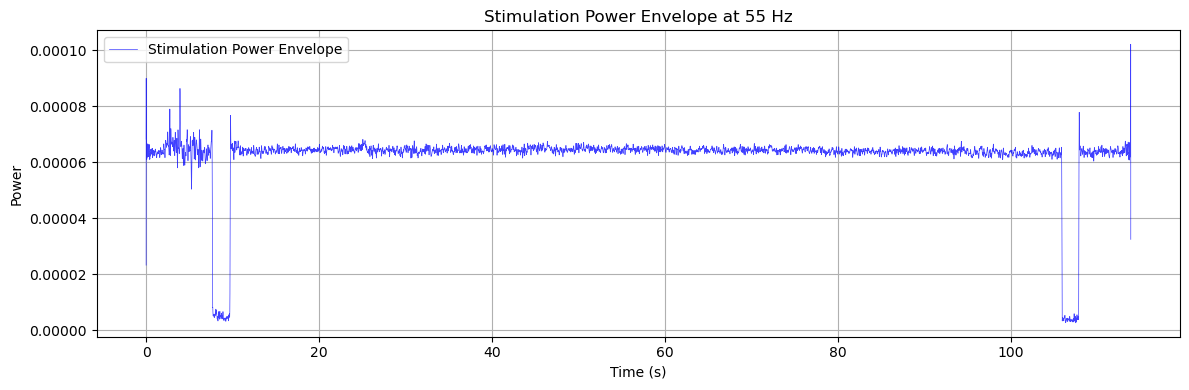

In [16]:
def extract_stim_power_envelope(raw_eeg, stim_freq=130.0, freq_tolerance=3, plot=True):
    """
    Extract stimulation power envelope from EEG using Hilbert transform.
    
    Parameters
    ----------
    raw_eeg : mne.io.Raw
        EEG raw data
    stim_freq : float
        Expected DBS stimulation frequency (Hz)
    freq_tolerance : float
        Frequency band width around stim_freq (Hz)
        
    Returns
    -------
    stim_power : np.ndarray
        Smoothed stimulation power envelope
    times : np.ndarray
        Time array in seconds
    """
    # Select EEG channels
    eeg_picks = mne.pick_types(raw_eeg.info, eeg=True)
    data = raw_eeg.get_data(picks=eeg_picks)
    sfreq = raw_eeg.info['sfreq']
    times = raw_eeg.times
    
    # Bandpass filter around stimulation frequency
    freq_low = stim_freq - freq_tolerance
    freq_high = stim_freq + freq_tolerance
    
    filtered = mne.filter.filter_data(
        data, sfreq=sfreq,
        l_freq=freq_low, 
        h_freq=freq_high,
        verbose=False
    )
    
    # Calculate envelope using Hilbert transform
    analytic = signal.hilbert(filtered, axis=1)
    envelope = np.abs(analytic)
    
    # Average across channels
    stim_power = np.mean(envelope, axis=0)
            
    print(f"\n原始功率范围: {np.min(stim_power):.6f} - {np.max(stim_power):.6f}")

    if plot:
        # Plot stimulation power envelope
        plt.figure(figsize=(12, 4))
        plt.plot(times, stim_power, label='Stimulation Power Envelope', color='blue', alpha=0.75, linewidth=0.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Power')
        plt.title(f'Stimulation Power Envelope at {stim_freq} Hz')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
    


    return  {'stim_power': stim_power, 'times': times}


# Extract stimulation power envelopeS
STIM_FREQ = 55  # Hz
results = extract_stim_power_envelope(raw_eeg_prep, stim_freq=STIM_FREQ, freq_tolerance=3)


Detected 2 STIM OFF Segments:
  OFF Segments 1: 7.67s - 9.71s (Time Duration: 2.04s)
  OFF Segments 2: 105.93s - 107.88s (Time Duration: 1.95s)

Duration difference between the two STIM OFF segments: 0.09s
✓ The durations are similar and within the expected range.


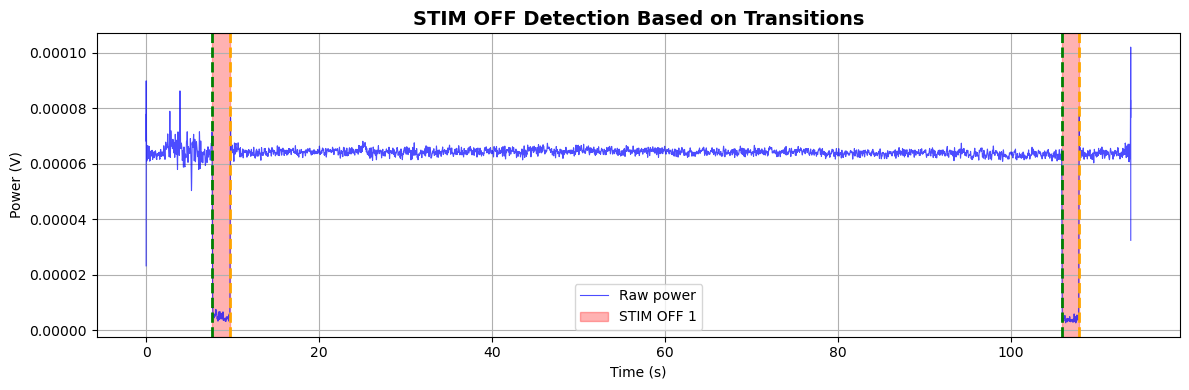

In [18]:
from scipy.ndimage import gaussian_filter1d

def detect_stim_off_by_transitions(stim_power, times, 
                                    min_off_duration=1.0,
                                    max_off_duration=10.0,
                                    smooth_sigma=50,
                                    derivative_threshold_std=3.0,
                                    plot=False):
    """
    通过检测信号突变来识别STIM OFF段。
    
    Parameters
    ----------
    stim_power : np.ndarray
        刺激功率数组（原始，未归一化）
    times : np.ndarray
        时间数组（秒）
    min_off_duration : float
        最小OFF段持续时间（秒）
    max_off_duration : float
        最大OFF段持续时间（秒）
    smooth_sigma : int
        高斯平滑的sigma（用于计算导数前）
    derivative_threshold_std : float
        导数阈值（标准差的倍数）
        
    Returns
    -------
    off_segments : list of dict
        检测到的STIM OFF段
    detection_info : dict
        检测过程的详细信息
    """
    
    # 采样率
    dt = times[1] - times[0]
    sfreq = 1.0 / dt
    
    # print("="*60)
    # print("基于突变检测的 STIM OFF 段识别")
    # print("="*60)
    # print(f"采样率: {sfreq:.1f} Hz")
    # print(f"信号长度: {len(stim_power)} 样本 ({times[-1]:.1f} 秒)")
    
    # Step 1: 轻度平滑以减少噪声
    power_smooth = gaussian_filter1d(stim_power, sigma=smooth_sigma)
    
    # Step 2: 计算一阶导数（变化率）
    derivative = np.gradient(power_smooth, dt)
    
    # Step 3: 找到显著的下降和上升点
    deriv_std = np.std(derivative)
    deriv_mean = np.mean(derivative)
    
    # 下降阈值（负值）
    drop_threshold = deriv_mean - derivative_threshold_std * deriv_std
    # 上升阈值（正值）
    rise_threshold = deriv_mean + derivative_threshold_std * deriv_std
    
    # print(f"\n导数统计:")
    # print(f"  均值: {deriv_mean:.2e}")
    # print(f"  标准差: {deriv_std:.2e}")
    # print(f"  下降阈值: {drop_threshold:.2e}")
    # print(f"  上升阈值: {rise_threshold:.2e}")
    
    # Step 4: 检测突降点和突升点
    # 找局部最小值（最大下降）
    drop_candidates = derivative < drop_threshold
    rise_candidates = derivative > rise_threshold
    
    # 找峰值位置
    drop_peaks, drop_props = signal.find_peaks(-derivative, 
                                                height=-drop_threshold,
                                                distance=int(sfreq * 0.5))  # 至少0.5秒间隔
    
    rise_peaks, rise_props = signal.find_peaks(derivative,
                                                height=rise_threshold,
                                                distance=int(sfreq * 0.5))
    
    # print(f"\n检测到 {len(drop_peaks)} 个突降点")
    # print(f"检测到 {len(rise_peaks)} 个突升点")
    
    # Step 5: 配对突降和突升点，形成OFF段
    off_segments = []
    
    for drop_idx in drop_peaks:
        drop_time = times[drop_idx]
        
        # 找这个下降点之后最近的上升点
        valid_rises = rise_peaks[rise_peaks > drop_idx]
        
        if len(valid_rises) > 0:
            rise_idx = valid_rises[0]
            rise_time = times[rise_idx]
            duration = rise_time - drop_time
            
            # 检查持续时间是否合理
            if min_off_duration <= duration <= max_off_duration:
                off_segments.append({
                    'start_time': drop_time,
                    'end_time': rise_time,
                    'duration': duration,
                    'start_idx': drop_idx,
                    'end_idx': rise_idx,
                    'drop_magnitude': -derivative[drop_idx],
                    'rise_magnitude': derivative[rise_idx]
                })
    
    print(f"\nDetected {len(off_segments)} STIM OFF Segments:")
    for i, seg in enumerate(off_segments):
        print(f"  OFF Segments {i+1}: {seg['start_time']:.2f}s - {seg['end_time']:.2f}s "
              f"(Time Duration: {seg['duration']:.2f}s)")
    
    # 检查两个OFF段时长是否相近
    if len(off_segments) >= 2:
        durations = [seg['duration'] for seg in off_segments]
        duration_diff = abs(durations[0] - durations[1])
        print(f"\nDuration difference between the two STIM OFF segments: {duration_diff:.2f}s")

        if duration_diff < 1.0:
            print("✓ The durations are similar and within the expected range.")
        else:
            print("⚠ The duration difference is large; you may need to adjust the parameters.")

    
    detection_info = {
        'power_smooth': power_smooth,
        'derivative': derivative,
        'drop_threshold': drop_threshold,
        'rise_threshold': rise_threshold,
        'drop_peaks': drop_peaks,
        'rise_peaks': rise_peaks
    }
    
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(times, stim_power, 'b-', linewidth=0.8, alpha=0.7, label='Raw power')
        for i, seg in enumerate(off_segments):
            plt.axvspan(seg['start_time'], seg['end_time'], color='red', alpha=0.3, label=f'STIM OFF {i+1}' if i == 0 else '')
            plt.axvline(seg['start_time'], color='green', linestyle='--', linewidth=2)
            plt.axvline(seg['end_time'], color='orange', linestyle='--', linewidth=2)

        plt.xlabel('Time (s)')
        plt.ylabel('Power (V)')
        plt.title(f'STIM OFF Detection Based on Transitions', fontsize=14, weight='bold')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()    
    
    return off_segments, detection_info

off_segments, detection_info = detect_stim_off_by_transitions(
    results['stim_power'], 
    results['times'],
    plot=True
)

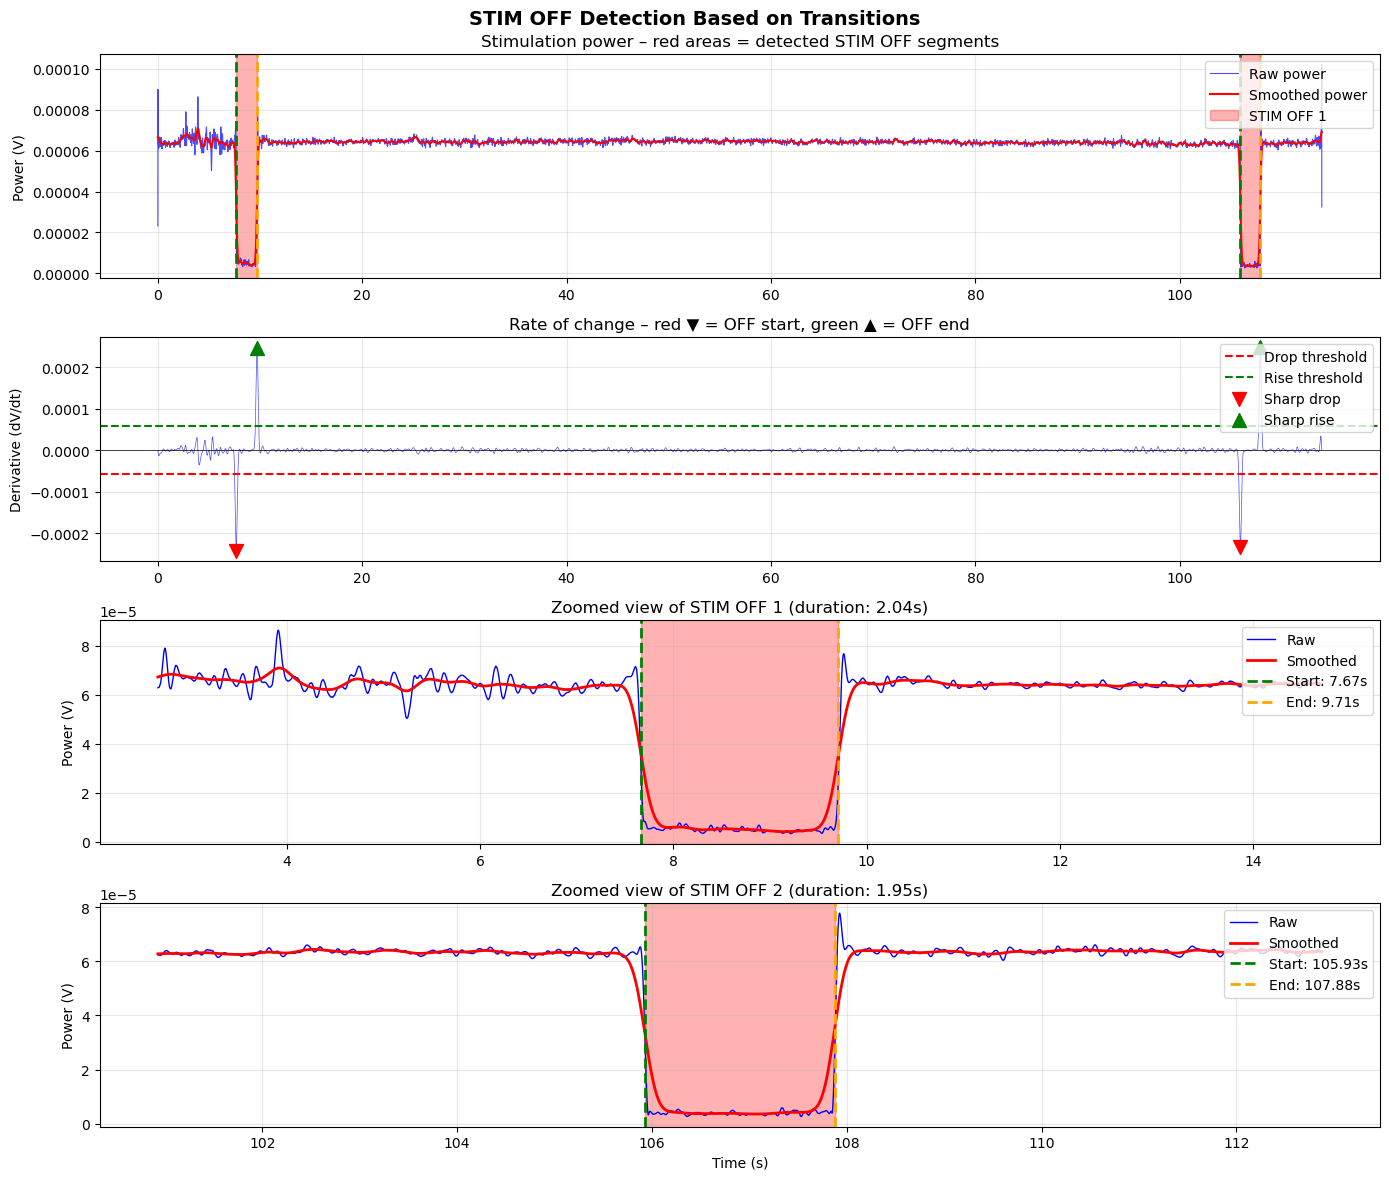

In [ ]:
def visualize_transition_detection(stim_power, times, off_segments, detection_info):
    """
    可视化突变检测结果。
    """
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('STIM OFF Detection Based on Transitions', fontsize=14, fontweight='bold')
    
    # ----------------------------------------
    # Plot 1: Raw power and detected STIM OFF segments
    # ----------------------------------------
    ax1 = axes[0]
    ax1.plot(times, stim_power, 'b-', linewidth=0.8, alpha=0.7, label='Raw power')
    ax1.plot(times, detection_info['power_smooth'], 'r-', linewidth=1.5, label='Smoothed power')
    
    # Mark OFF segments
    for i, seg in enumerate(off_segments):
        ax1.axvspan(seg['start_time'], seg['end_time'], 
                    alpha=0.3, color='red', label=f'STIM OFF {i+1}' if i == 0 else '')
        ax1.axvline(seg['start_time'], color='green', linestyle='--', linewidth=2)
        ax1.axvline(seg['end_time'], color='orange', linestyle='--', linewidth=2)
    
    ax1.set_ylabel('Power (V)')
    ax1.set_title('Stimulation power – red areas = detected STIM OFF segments')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # Plot 2: First derivative (rate of change)
    # ----------------------------------------
    ax2 = axes[1]
    derivative = detection_info['derivative']
    ax2.plot(times, derivative, 'b-', linewidth=0.5, alpha=0.7)
    
    # Threshold lines
    ax2.axhline(detection_info['drop_threshold'], color='red', linestyle='--', 
                label='Drop threshold')
    ax2.axhline(detection_info['rise_threshold'], color='green', linestyle='--',
                label='Rise threshold')
    ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
    
    # Mark detected transition points
    drop_peaks = detection_info['drop_peaks']
    rise_peaks = detection_info['rise_peaks']
    
    ax2.scatter(times[drop_peaks], derivative[drop_peaks], 
                c='red', s=100, zorder=5, label='Sharp drop', marker='v')
    ax2.scatter(times[rise_peaks], derivative[rise_peaks],
                c='green', s=100, zorder=5, label='Sharp rise', marker='^')
    
    ax2.set_ylabel('Derivative (dV/dt)')
    ax2.set_title('Rate of change – red ▼ = OFF start, green ▲ = OFF end')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # Plot 3: Zoom into the first STIM OFF segment
    # ----------------------------------------
    ax3 = axes[2]
    if len(off_segments) > 0:
        seg = off_segments[0]
        margin = 5  # seconds before/after
        t_start = max(0, seg['start_time'] - margin)
        t_end = min(times[-1], seg['end_time'] + margin)
        
        mask = (times >= t_start) & (times <= t_end)
        ax3.plot(times[mask], stim_power[mask], 'b-', linewidth=1, label='Raw')
        ax3.plot(times[mask], detection_info['power_smooth'][mask], 'r-', 
                 linewidth=2, label='Smoothed')
        
        ax3.axvspan(seg['start_time'], seg['end_time'], alpha=0.3, color='red')
        ax3.axvline(seg['start_time'], color='green', linestyle='--', linewidth=2,
                    label=f"Start: {seg['start_time']:.2f}s")
        ax3.axvline(seg['end_time'], color='orange', linestyle='--', linewidth=2,
                    label=f"End: {seg['end_time']:.2f}s")
        
        ax3.set_title(f"Zoomed view of STIM OFF 1 (duration: {seg['duration']:.2f}s)")
        ax3.legend(loc='upper right')
    ax3.set_ylabel('Power (V)')
    ax3.grid(True, alpha=0.3)
    
    # ----------------------------------------
    # Plot 4: Zoom into the second STIM OFF segment
    # ----------------------------------------
    ax4 = axes[3]
    if len(off_segments) > 1:
        seg = off_segments[1]
        margin = 5
        t_start = max(0, seg['start_time'] - margin)
        t_end = min(times[-1], seg['end_time'] + margin)
        
        mask = (times >= t_start) & (times <= t_end)
        ax4.plot(times[mask], stim_power[mask], 'b-', linewidth=1, label='Raw')
        ax4.plot(times[mask], detection_info['power_smooth'][mask], 'r-',
                 linewidth=2, label='Smoothed')
        
        ax4.axvspan(seg['start_time'], seg['end_time'], alpha=0.3, color='red')
        ax4.axvline(seg['start_time'], color='green', linestyle='--', linewidth=2,
                    label=f"Start: {seg['start_time']:.2f}s")
        ax4.axvline(seg['end_time'], color='orange', linestyle='--', linewidth=2,
                    label=f"End: {seg['end_time']:.2f}s")
        
        ax4.set_title(f"Zoomed view of STIM OFF 2 (duration: {seg['duration']:.2f}s)")
        ax4.legend(loc='upper right')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Power (V)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


stim_power = results['stim_power'] 
times = results['times']


fig = visualize_transition_detection(stim_power, times, off_segments, detection_info)


In [21]:
annotations = mne.Annotations(
    onset=[seg['start_time'] for seg in off_segments],
    duration=[seg['duration'] for seg in off_segments],
    description=['STIM_OFF', 'STIM_OFF']
)

raw_eeg.set_annotations(annotations)
print(raw_eeg.annotations)
raw_eeg.plot(n_channels=10, duration=30.0, scalings='auto')

<Annotations | 2 segments: STIM_OFF (2)>


In [ ]:
def detect_stim_events_from_lfp(df_stim, stim_column='stim_on', 
                                 time_column='timestamp'):
    """
    Extract STIM_ON and STIM_OFF events from LFP stimulation time series.
    
    Parameters
    ----------
    df_stim : pd.DataFrame
        DataFrame with columns: 'timestamp' (seconds), 'stim_on' (bool/0-1)
    stim_column : str
        Column name for stimulation state
    time_column : str
        Column name for timestamps
        
    Returns
    -------
    events_list : list of dict
        List of events with keys:
        - 'event_type': 'STIM_ON' or 'STIM_OFF'
        - 'time_sec': event time in seconds
        - 'sample_idx': sample index
        - 'segment_id': segment number
    """
    # Get stimulation state and times
    stim_state = df_stim[stim_column].values.astype(bool)
    times = df_stim[time_column].values
    
    # Detect transitions (add boundary padding)
    stim_padded = np.concatenate([[False], stim_state, [False]])
    transitions = np.diff(stim_padded.astype(int))
    
    # Find ON (0→1) and OFF (1→0) transitions
    on_indices = np.where(transitions == 1)[0]
    off_indices = np.where(transitions == -1)[0]
    
    print(f"Found {len(on_indices)} STIM_ON events")
    print(f"Found {len(off_indices)} STIM_OFF events")
    
    # Create events list
    events_list = []
    segment_id = 0
    
    for on_idx, off_idx in zip(on_indices, off_indices):
        # STIM_ON event
        events_list.append({
            'event_type': 'STIM_ON',
            'time_sec': times[on_idx],
            'sample_idx': on_idx,
            'segment_id': segment_id
        })
        
        # STIM_OFF event
        events_list.append({
            'event_type': 'STIM_OFF',
            'time_sec': times[off_idx - 1] if off_idx > 0 else times[off_idx],
            'sample_idx': off_idx - 1 if off_idx > 0 else off_idx,
            'segment_id': segment_id
        })
        
        segment_id += 1
    
    # Sort by time
    events_list.sort(key=lambda x: x['time_sec'])
    
    return events_list